In [5]:
%pip install torch-snippets


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: C:\Users\daneil\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [6]:
import os
import requests
from zipfile import ZipFile

# Verifica se o diretório 'Faceswap-Deepfake-Pytorch' não existe
if not os.path.exists('Faceswap-Deepfake-Pytorch'):
    # Baixa o arquivo zip
    url_zip = 'https://www.dropbox.com/s/5ji7jl7httso9ny/person_images.zip?dl=1'
    response_zip = requests.get(url_zip)
    with open('person_images.zip', 'wb') as f:
        f.write(response_zip.content)
    
    # Baixa o script Python
    url_script = 'https://raw.githubusercontent.com/sizhky/deep-fake-util/main/random_warp.py'
    response_script = requests.get(url_script)
    with open('random_warp.py', 'wb') as f:
        f.write(response_script.content)
    
    # Descompacta o arquivo zip
    with ZipFile('person_images.zip', 'r') as zip_ref:
        zip_ref.extractall()

# Importa bibliotecas
from torch_snippets import *
from random_warp import get_training_data


In [7]:
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [8]:
def crop_face(img):
    # Converte a imagem de BGR para escala de cinza
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    # Detecta faces na imagem em escala de cinza usando o classificador em cascata
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)
    
    # Verifica se pelo menos uma face foi detectada
    if len(faces) > 0:
        # Itera sobre todas as faces detectadas
        for (x, y, w, h) in faces:
            # Recorta a região da imagem onde a face foi detectada
            img2 = img[y:(y+h), x:(x+w), :]
        
        # Redimensiona a imagem recortada para 256x256 pixels
        img2 = cv2.resize(img2, (256, 256))
        
        # Retorna a imagem recortada e True indicando que a face foi detectada
        return img2, True
    else:
        # Se nenhuma face for detectada, retorna a imagem original e False
        return img, False


In [9]:
!mkdir cropped_faces_personA
!mkdir cropped_faces_personB

def crop_images(folder):
    # Obtém a lista de imagens JPG na pasta especificada
    images = Glob(folder + '/*.jpg')
    
    # Itera sobre cada imagem na lista
    for i in range(len(images)):
        # Lê a imagem em escala de cinza
        img = read(images[i], 1)
        
        # Aplica a função crop_face para detectar e recortar a face
        img2, face_detected = crop_face(img)
        
        # Verifica se a face foi detectada
        if face_detected == False:
            continue  # Se não houver face, pula para a próxima imagem
        else:
            # Se a face foi detectada, salva a imagem recortada
            # O caminho de destino inclui o diretório específico e o índice da imagem
            cv2.imwrite('cropped_faces_' + folder + '/' + str(i) + '.jpg', cv2.cvtColor(img2, cv2.COLOR_RGB2BGR))

crop_images('personA')
crop_images('personB')

In [10]:

class ImageDataset(Dataset):
    def __init__(self, items_A, items_B):
        """
        Inicializa o dataset de imagens para duas categorias (A e B).
        
        :param items_A: Lista de caminhos para as imagens da categoria A.
        :param items_B: Lista de caminhos para as imagens da categoria B.
        """
        # Lê e normaliza as imagens das duas categorias, ajustando a média das imagens da categoria A
        self.items_A = np.concatenate([read(f,1)[None] for f in items_A])/255.
        self.items_B = np.concatenate([read(f,1)[None] for f in items_B])/255.
        # Ajusta a média das imagens da categoria A para que coincidam com a média das imagens da categoria B
        self.items_A += self.items_B.mean(axis=(0, 1, 2)) - self.items_A.mean(axis=(0, 1, 2))

    def __len__(self):
        return min(len(self.items_A), len(self.items_B))

    def __getitem__(self, ix):
        ##Obtém uma amostra aleatória do dataset, uma da categoria A e uma da categoria B.
        a, b = choose(self.items_A), choose(self.items_B)
        return a, b

    def collate_fn(self, batch):=
        # Separa o batch em imagens da categoria A e B
        imsA, imsB = list(zip(*batch))
        # Obtém dados de treinamento para as imagens e rótulos
        imsA, targetA = get_training_data(imsA, len(imsA))
        imsB, targetB = get_training_data(imsB, len(imsB))
        # Converte as imagens e rótulos para tensores e ajusta as dimensões para PyTorch
        imsA, imsB, targetA, targetB = [torch.Tensor(i).permute(0,3,1,2).to(device) for i in [imsA, imsB, targetA, targetB]]
        return imsA, imsB, targetA, targetB

# Cria uma instância do dataset usando os caminhos das imagens das duas categorias
a = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
# Cria um DataLoader para o dataset, especificando o tamanho do batch e a função de colagem personalizada
x = DataLoader(a, batch_size=32, collate_fn=a.collate_fn)


══════════════════════════════════════════════════════════════════
tensor([[[[0.4745, 0.4577, 0.4545,  ..., 0.5769, 0.5219, 0.4589],
          [0.4537, 0.4401, 0.4473,  ..., 0.6031, 0.5452, 0.4803],
          [0.4438, 0.4402, 0.4497,  ..., 0.6224, 0.5730, 0.5020],
          ...,
          [0.5178, 0.5025, 0.5120,  ..., 0.6000, 0.5922, 0.5870],
          [0.4986, 0.4971, 0.5015,  ..., 0.5927, 0.5849, 0.5810],
          [0.4842, 0.4793, 0.4859,  ..., 0.5893, 0.5822, 0.5753]],

         [[0.3861, 0.3693, 0.3661,  ..., 0.4532, 0.4009, 0.3460],
          [0.3657, 0.3517, 0.3589,  ..., 0.4748, 0.4250, 0.3689],
          [0.3534, 0.3518, 0.3613,  ..., 0.5000, 0.4531, 0.3900],
          ...,
          [0.4959, 0.4625, 0.4540,  ..., 0.4606, 0.4609, 0.4589],
          [0.4868, 0.4597, 0.4494,  ..., 0.4608, 0.4568, 0.4534],
          [0.4740, 0.4491, 0.4406,  ..., 0.4616, 0.4555, 0.4516]],

         [[0.2447, 0.2317, 0.2290,  ..., 0.3627, 0.3131, 0.2559],
          [0.2224, 0.2137, 0.2213,  ..., 

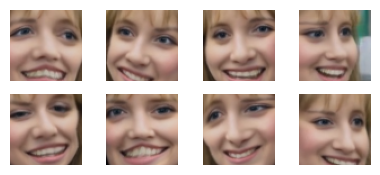

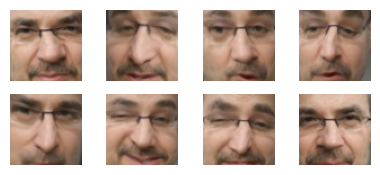

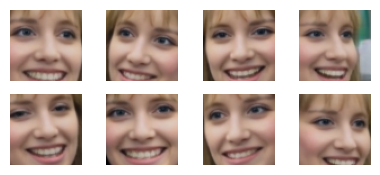

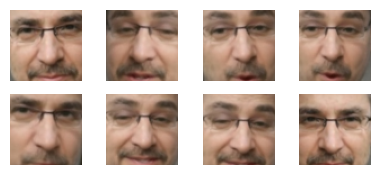

In [11]:
inspect(*next(iter(x)))

# Itera sobre o próximo lote do DataLoader `x` e exibe as primeiras 8 imagens em uma grade de 4 colunas
for i in next(iter(x)):
    subplots(i[:8], nc=4, sz=(4,2))

In [12]:
def _ConvLayer(input_features, output_features):
    """
    Cria uma camada convolucional seguida por uma ativação LeakyReLU.
    """
    return nn.Sequential(
        nn.Conv2d(input_features, output_features, kernel_size=5, stride=2, padding=2),
        nn.LeakyReLU(0.1, inplace=True)
    )

def _UpScale(input_features, output_features):
    """
    Cria uma camada de convolução transposta (upsampling) seguida por uma ativação LeakyReLU.
    """
    return nn.Sequential(
        nn.ConvTranspose2d(input_features, output_features, kernel_size=2, stride=2, padding=0),
        nn.LeakyReLU(0.1, inplace=True)
    )

class Reshape(nn.Module):
    def forward(self, input):
        """
        Redimensiona a entrada para a forma [batch_size, 1024, 4, 4].
        """
        output = input.view(-1, 1024, 4, 4) # Reshape para canais * 4 * 4
        return output


In [13]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()

        # Encoder que reduz a resolução e extrai características, seguido por uma camada totalmente conectada e reshape
        self.encoder = nn.Sequential(
            _ConvLayer(3, 128),
            _ConvLayer(128, 256),
            _ConvLayer(256, 512),
            _ConvLayer(512, 1024),
            nn.Flatten(),
            nn.Linear(1024 * 4 * 4, 1024),
            nn.Linear(1024, 1024 * 4 * 4),
            Reshape(),
            _UpScale(1024, 512),
        )

        # Decodificadores que restauram a resolução das imagens, uma para cada tipo de saída (A e B)
        self.decoder_A = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

        self.decoder_B = nn.Sequential(
            _UpScale(512, 256),
            _UpScale(256, 128),
            _UpScale(128, 64),
            nn.Conv2d(64, 3, kernel_size=3, padding=1),
            nn.Sigmoid(),
        )

    def forward(self, x, select='A'):
        # Escolhe o decodificador A ou B com base na seleção
        if select == 'A':
            out = self.encoder(x)
            out = self.decoder_A(out)
        else:
            out = self.encoder(x)
            out = self.decoder_B(out)
        return out


In [14]:
def train_batch(model, data, criterion, optimizers):
    optA, optB = optimizers
    optA.zero_grad()
    optB.zero_grad()
    imgA, imgB, targetA, targetB = data
    # Executa o modelo para obter as reconstruções para as imagens A e B
    _imgA, _imgB = model(imgA, 'A'), model(imgB, 'B')

    # Calcula a perda para as imagens A e B
    lossA = criterion(_imgA, targetA)
    lossB = criterion(_imgB, targetB)
    
    lossA.backward()
    lossB.backward()

    # Atualiza os parâmetros dos otimizadores
    optA.step()
    optB.step()

    return lossA.item(), lossB.item()


In [15]:
model = Autoencoder().to(device)
# Cria e move o modelo Autoencoder para o dispositivo (GPU/CPU)

dataset = ImageDataset(Glob('cropped_faces_personA'), Glob('cropped_faces_personB'))
# Inicializa o dataset com imagens das pastas 'personA' e 'personB'

dataloader = DataLoader(dataset, 32, collate_fn=dataset.collate_fn)
# Cria um DataLoader para o dataset com batch size 32 e função de colagem personalizada

optimizers = optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_A.parameters()}],
                        lr=5e-5, betas=(0.5, 0.999)), \
             optim.Adam([{'params': model.encoder.parameters()},
                          {'params': model.decoder_B.parameters()}], 
                        lr=5e-5, betas=(0.5, 0.999))
# Define dois otimizadores Adam para as partes do modelo, cada um com taxa de aprendizado e parâmetros beta

criterion = nn.L1Loss()
# Define a função de perda L1 (erro absoluto médio) para treinamento


EPOCH: 1.000  lossB: 0.148  lossA: 0.137  (22.52s - 202.66s remaining)
EPOCH: 2.000  lossB: 0.146  lossA: 0.137  (45.47s - 181.86s remaining)
══════════════════════════════A TO B══════════════════════════════


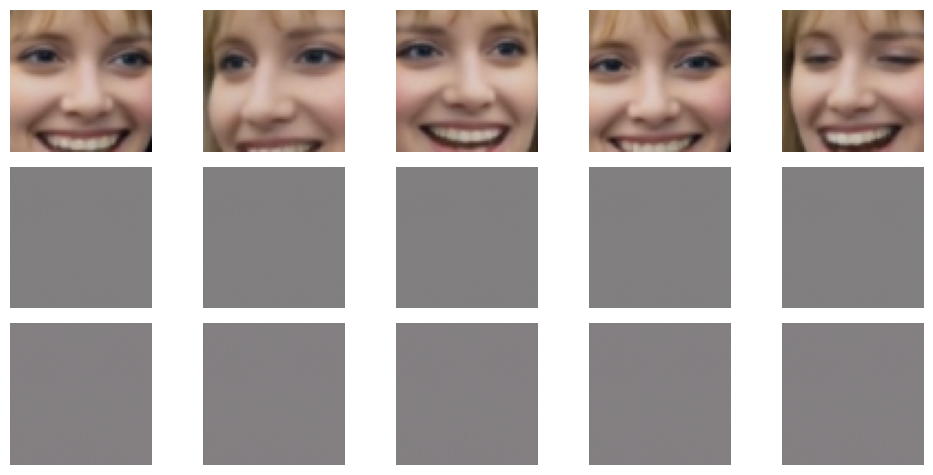

══════════════════════════════B TO A══════════════════════════════


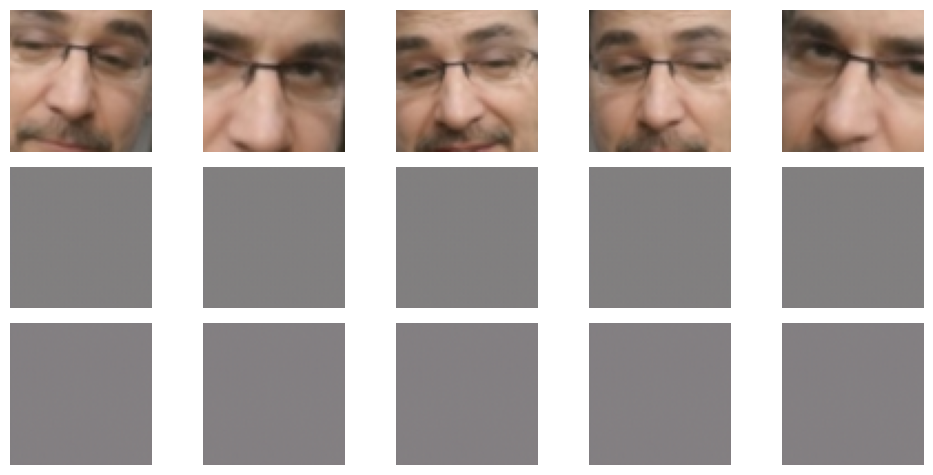

EPOCH: 3.000  lossB: 0.143  lossA: 0.136  (71.46s - 166.75s remaining)
EPOCH: 4.000  lossB: 0.124  lossA: 0.121  (94.41s - 141.61s remaining)
══════════════════════════════A TO B══════════════════════════════


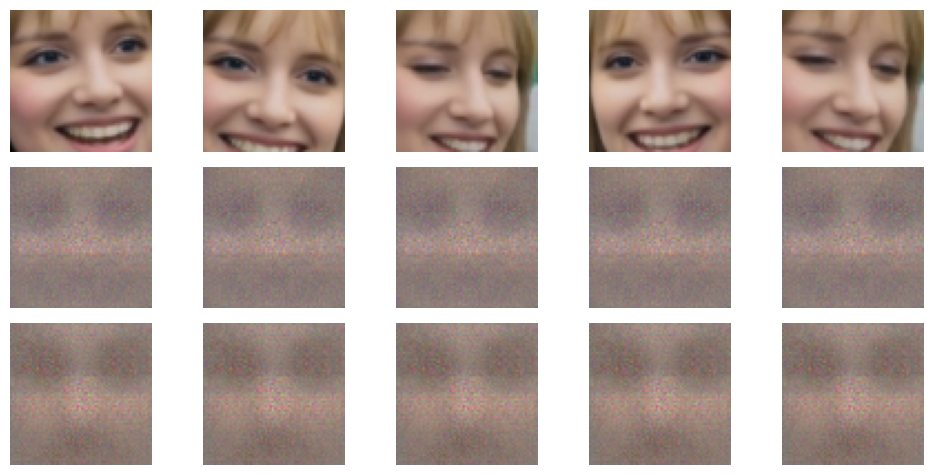

══════════════════════════════B TO A══════════════════════════════


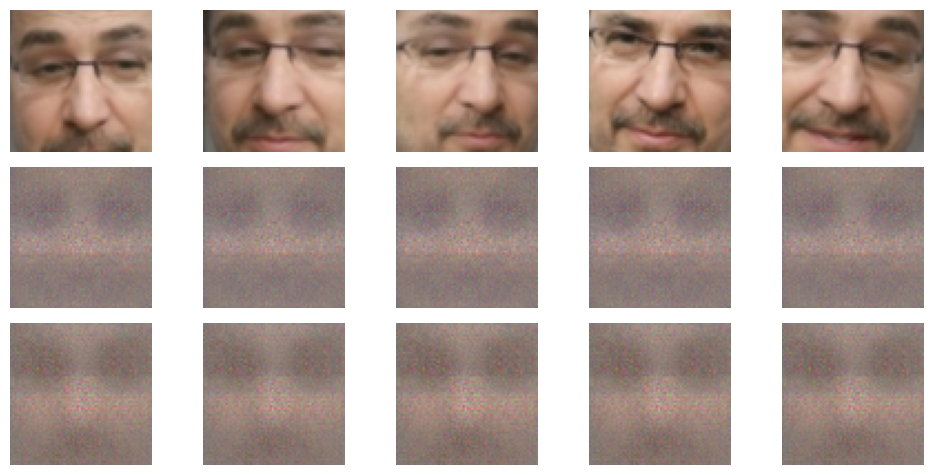

EPOCH: 5.000  lossB: 0.114  lossA: 0.108  (119.43s - 119.43s remaining)
EPOCH: 6.000  lossB: 0.102  lossA: 0.094  (142.52s - 95.01s remaining))
══════════════════════════════A TO B══════════════════════════════


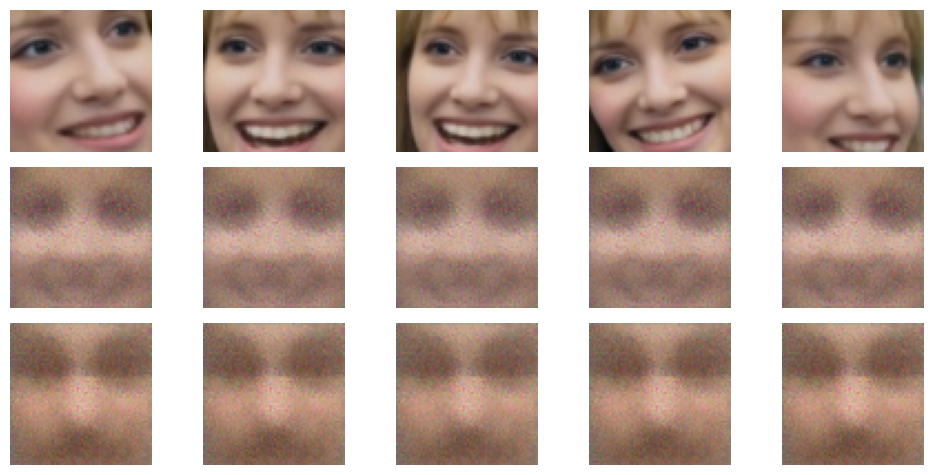

══════════════════════════════B TO A══════════════════════════════


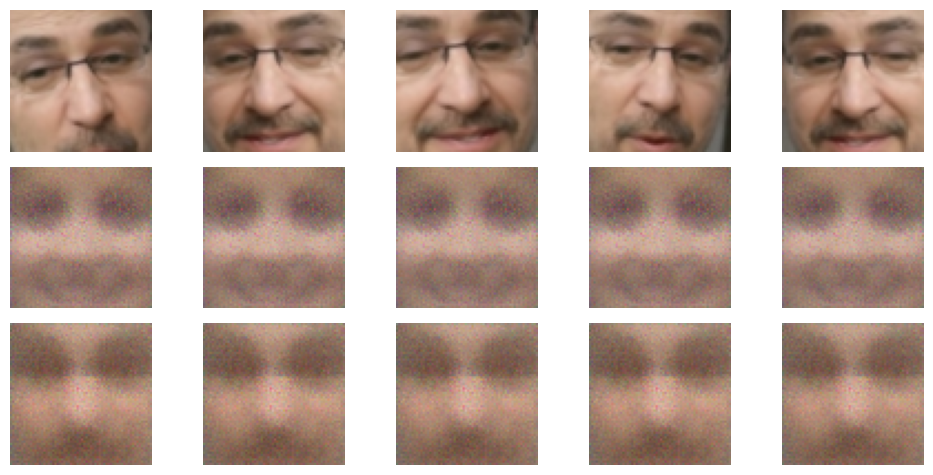

EPOCH: 7.000  lossB: 0.104  lossA: 0.095  (168.11s - 72.05s remaining)
EPOCH: 8.000  lossB: 0.098  lossA: 0.093  (190.79s - 47.70s remaining)
══════════════════════════════A TO B══════════════════════════════


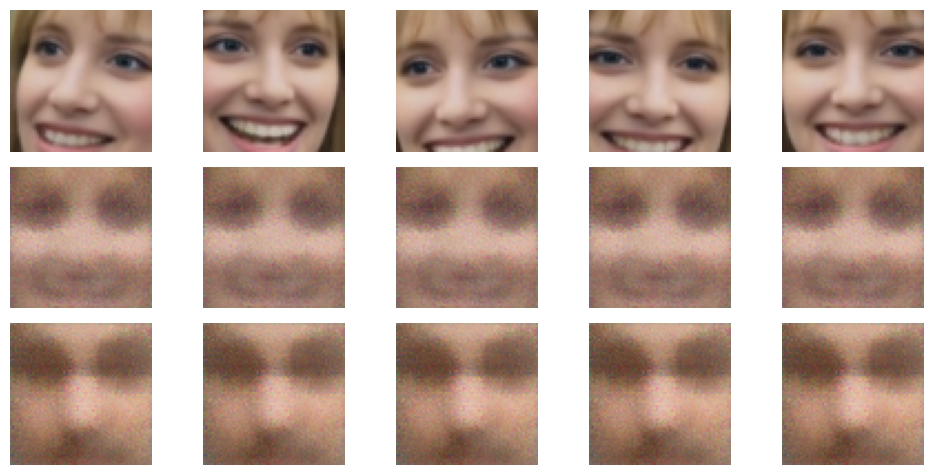

══════════════════════════════B TO A══════════════════════════════


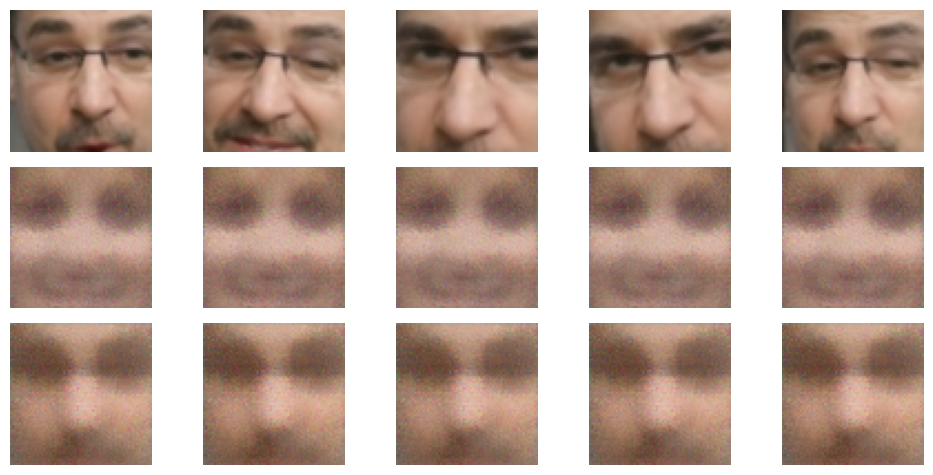

EPOCH: 9.000  lossB: 0.100  lossA: 0.093  (216.11s - 24.01s remaining)
EPOCH: 10.000  lossB: 0.099  lossA: 0.089  (238.76s - 0.00s remaining)
══════════════════════════════A TO B══════════════════════════════


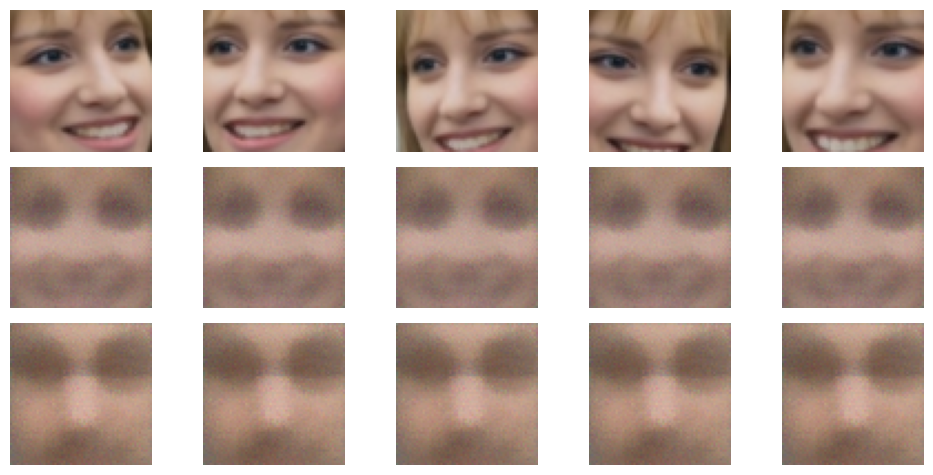

══════════════════════════════B TO A══════════════════════════════


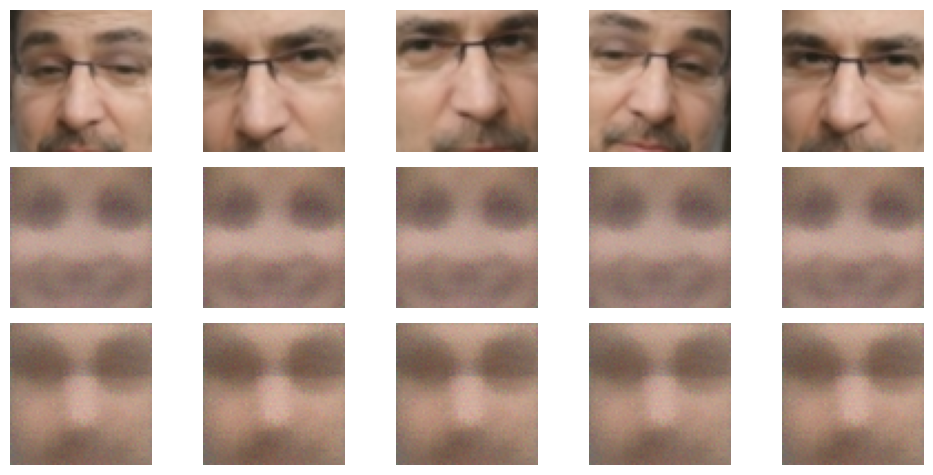

100%|██████████| 111/111 [00:00<00:00, 55550.38it/s]


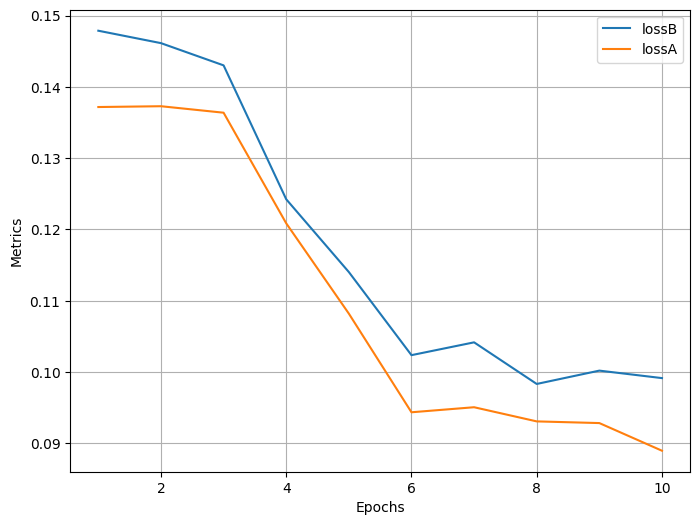

In [16]:
n_epochs = 10
log = Report(n_epochs)
# Define o número de épocas e inicializa um objeto para registrar os resultados

!mkdir checkpoint
# Cria um diretório para salvar os checkpoints do modelo

for ex in range(n_epochs):
    N = len(dataloader)
    for bx, data in enumerate(dataloader):
        lossA, lossB = train_batch(model, data, criterion, optimizers)
        # Treina o modelo em um batch e registra a perda
        log.record(ex + (1 + bx) / N, lossA=lossA, lossB=lossB, end='\r')

    log.report_avgs(ex + 1)
    # Relata as médias de perda para a época

    if (ex + 1) % 2 == 0:
        # Salva o checkpoint a cada 2 épocas
        state = {
            'state': model.state_dict(),
            'epoch': ex
        }
        torch.save(state, './checkpoint/autoencoder.pth')

    if (ex + 1) % 2 == 0:
        bs = 5
        a, b, A, B = data
        line('A to B')
        _a = model(a[:bs], 'A')
        _b = model(a[:bs], 'B')
        x = torch.cat([A[:bs], _a, _b])
        subplots(x, nc=bs, figsize=(bs * 2, 5))

        line('B to A')
        _a = model(b[:bs], 'A')
        _b = model(b[:bs], 'B')
        x = torch.cat([B[:bs], _a, _b])
        subplots(x, nc=bs, figsize=(bs * 2, 5))

log.plot_epochs()
# Plota o progresso do treinamento ao longo das épocas
